# Creating the Escudero-Sanz eye model with ZOSPy

This example shows how to create and analyze a wide-angle eye model described in the paper _[Off-axis aberrations of a wide-angle schematic eye model](https://doi.org/10.1364/JOSAA.16.001881)_ by I. Escudero-Sanz and R. Navarro.

## Included functionalities

* _Sequential mode_:
  - Usage of `zospy.solvers.material_model()` to model the refractive index of the elements of the eye.
  - Usage of `zospy.analyses.viewers.viewer_3d` and `zospy.analyses.viewers.shaded_model()` to open viewers.
  - Usage of `zospy.analyses.psf.huygens_psf()` to perform a Huygens PSF analysis.

## Citation

Next to [citing ZOSPy](/#referencing), please also cite the following paper when using the data provided in this example:

> Escudero-Sanz, I. & Navarro, R. (1999).
> Off-axis aberrations of a wide-angle schematic eye model.
> Journal of the Optical Society of America A, 16(8), 1881-1891. 
> https://doi.org/10.1364/JOSAA.16.001881

## Warranty and liability

The examples are provided 'as is'. There is no warranty and rights cannot be derived from them, as is also stated in the general license of this repository.

## Import dependencies

In [1]:
from warnings import warn

import matplotlib.pyplot as plt
import pandas as pd

import zospy as zp
from zospy import solvers
from zospy.analyses import OnComplete

## Define eye model

In [2]:
wavelength = 543.0  # nm

Define the refractive index of the optical elements of the eye

In [3]:
refinds = pd.DataFrame(
    columns=[458, 543, 589.3, 632.8],
    index=["Cornea", "Aqueous", "Lens", "Vitreous"],
    data=[
        [1.3828, 1.3777, 1.376, 1.3747],
        [1.3445, 1.3391, 1.3374, 1.336],
        [1.4292, 1.4222, 1.42, 1.4183],
        [1.3428, 1.3377, 1.336, 1.3347],
    ],
)

Define the eye model geometry

In [4]:
# Cornea front
cf_radius = 7.72  # mm
cf_conic = -0.26
cf_thickness = 0.55  # mm

# Cornea back
cb_radius = 6.50  # mm
cb_conic = 0
cb_thickness = 3.05  # mm

# Pupil
pupil_semidiameter = 1.5  # mm

# Lens front
lf_radius = 10.20  # mm
lf_conic = -3.1316
lf_thickness = 4.00  # mm

# Lens back
lb_radius = -6.00  # mm
lb_conic = -1.0
lb_thickness = 16.3202  # mm

# Retina
ret_radius = -12.00  # mm
ret_conic = 0

## Connect to OpticStudio

In [5]:
zos = zp.ZOS()
oss = zos.connect(mode="extension")

## Create model

Open a new optical system and put it in sequential mode

In [6]:
oss.new()
oss.make_sequential()

True

In [7]:
# set wavelength
wl_1 = oss.SystemData.Wavelengths.GetWavelength(1)
wl_1.Wavelength = wavelength / 1000  # convert to nanometer

# Set aperture type
oss.SystemData.Aperture.ApertureType = zp.constants.SystemData.ZemaxApertureType.FloatByStopSize

In [8]:
# input beam (to visualize the input beam in the system viewer)
input_beam = oss.LDE.InsertNewSurfaceAt(1)
input_beam.Comment = "InputBeam"
input_beam.Thickness = 10  # mm

# cornea front
cornea_front = oss.LDE.InsertNewSurfaceAt(2)
cornea_front.Comment = "Cornea Front"
cornea_front.Radius = cf_radius
cornea_front.Conic = cf_conic
cornea_front.SemiDiameter = 6  # mm
cornea_front.MechanicalSemiDiameter = 6  # mm
cornea_front.Thickness = cf_thickness
solvers.material_model(cornea_front.MaterialCell, refinds.loc["Cornea", wavelength], 0, 0)

# cornea back
cornea_back = oss.LDE.InsertNewSurfaceAt(3)
cornea_back.Comment = "Cornea Back"
cornea_back.Radius = cb_radius
cornea_back.Conic = cb_conic
cornea_back.SemiDiameter = 5  # mm
cornea_back.MechanicalSemiDiameter = 6  # mm
cornea_back.Thickness = cb_thickness
solvers.material_model(cornea_back.MaterialCell, refinds.loc["Aqueous", wavelength], 0, 0)

# iris/pupil
iris = oss.LDE.GetSurfaceAt(4)
iris.Comment = "Iris"
iris.SemiDiameter = pupil_semidiameter
iris.MechanicalSemiDiameter = 6  # mm
solvers.material_model(iris.MaterialCell, refinds.loc["Aqueous", wavelength], 0, 0)

# Lens front
lens_front = oss.LDE.InsertNewSurfaceAt(5)
lens_front.Comment = "Lens Front"
lens_front.Radius = lf_radius
lens_front.Conic = lf_conic
lens_front.SemiDiameter = 4.5  # mm
lens_front.MechanicalSemiDiameter = 4.5  # mm
lens_front.Thickness = lf_thickness
solvers.material_model(lens_front.MaterialCell, refinds.loc["Lens", wavelength], 0, 0)

# Lens back
lens_back = oss.LDE.InsertNewSurfaceAt(6)
lens_back.Comment = "Lens Back"
lens_back.Radius = lb_radius
lens_back.Conic = lb_conic
lens_back.SemiDiameter = 4.5  # mm
lens_back.MechanicalSemiDiameter = 4.5  # mm
lens_back.Thickness = lb_thickness
solvers.material_model(lens_back.MaterialCell, refinds.loc["Vitreous", wavelength], 0, 0)

# Retina
retina = oss.LDE.GetSurfaceAt(7)
retina.Comment = "Retina"
retina.Radius = ret_radius
retina.Conic = ret_conic
retina.SemiDiameter = 12  # mm
solvers.material_model(retina.MaterialCell, refinds.loc["Vitreous", wavelength], 0, 0)

## Plot the eye model using OpticStudio's 3D layout function 

In [9]:
# Define plot settings
cornea_front.DrawData.DoNotDrawEdgesFromThisSurface = False
cornea_back.DrawData.DoNotDrawEdgesFromThisSurface = True
iris.DrawData.DoNotDrawEdgesFromThisSurface = True
lens_front.DrawData.DoNotDrawEdgesFromThisSurface = False
lens_back.DrawData.DoNotDrawEdgesFromThisSurface = True

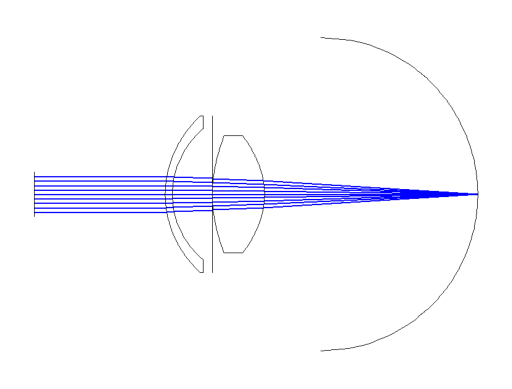

In [ ]:
def draw_model(oss):
    """Draw the eye model in the 3D viewer, or warn if the version of OpticStudio does not support this feature."""
    cross_section = zp.analyses.systemviewers.cross_section(
        oss, delete_vignetted=True, number_of_rays=11, line_thickness="Thick"
    )
    zp.analyses.systemviewers.shaded_model(oss, oncomplete=OnComplete.Release)

    if zos.version < (24, 1, 0):
        warn("Exporting the 3D viewer data is not available for this version of OpticStudio.")
    else:
        plt.imshow(cross_section.Data)
        plt.axis("off")


draw_model(oss)

## Compute and plot the Huygens Point Spread Function of the eye model

In [11]:
psf = zp.analyses.psf.huygens_psf(oss, "256x256", "256x256", normalize=False, oncomplete=OnComplete.Sustain)

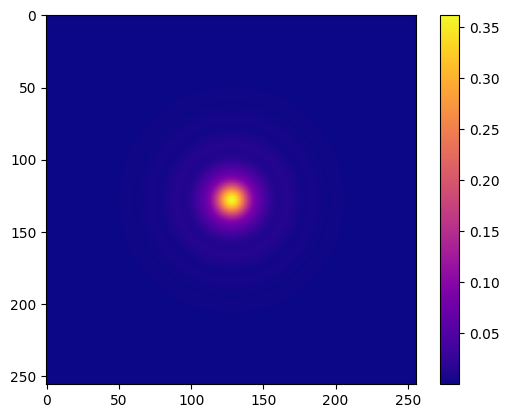

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(psf.Data, cmap="plasma")
plt.colorbar(im)

## Redo these calculations for light at a different eccentricity

In [13]:
field1 = oss.SystemData.Fields.GetField(1)
field1.Y = 15  # degrees

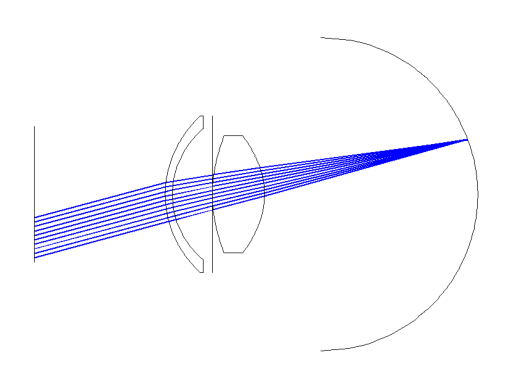

In [14]:
# Visualize the new beam settings
draw_model(oss)

Recalculate the Huygens point spread function

In [15]:
psf = zp.analyses.psf.huygens_psf(oss, "256x256", "256x256", normalize=False, oncomplete=OnComplete.Sustain)

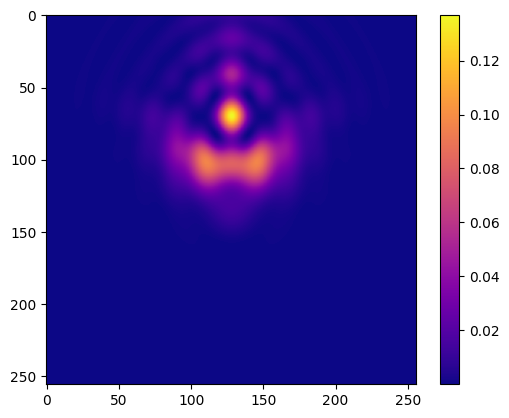

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(psf.Data, cmap="plasma")
plt.colorbar(im)